In [4]:
import copy
import json
import os
import sys

from scipy.stats import pearsonr
import numpy as np

from src.common.audioviz_dataset import AudiovizDataset
from src.common.audioviz_datastore import AudiovizDataStoreFactory
from src.common.evaluation import normalize_scores, recalculate_scores, format_metrics
from src.common.fun_call import FunCallFactory
from src.common.utils import DATA_DIMRED_DIR, DATA_FEATURES_DIR
from src.dimred.dimred import apply_dimred
from src.dimred.dimred_algorithms import parse_dimred_algorithm, DimredAlgorithmFactory
from src.features.build_features import get_features, parse_feature_extractor
from src.features.feature_extractors import FeatureExtractorFactory
from src.visualization.visualize import plot_grid_search, plot2D
from src.visualization.visualize import plot_samples


# select only the training subset
dataset = AudiovizDataset.load("medley_solos_db")

# define the combinations of features we want to use
stat_shorten = DimredAlgorithmFactory.get_instance(name="stat_shorten", args={})

rms = {"name": "rms", "args": {}}
Spectral_Centroid = {"name": "Spectral_Centroid", "args": {}}
Spectral_Crest = {"name": "Spectral_Crest", "args": {}}
Spectral_Flux = {"name": "Spectral_Flux", "args": {}}
Spectral_Roll = {"name": "Spectral_Roll", "args": {}}
Zerocrossing_Rate = {"name": "Zerocrossing_Rate", "args": {}}
stft = {"name": "stft", "args": {}}
mfcc = {"name": "mfcc", "args": {}}

raw_features = [
    rms,
    Spectral_Centroid,
    Spectral_Crest,
    Spectral_Flux,
    Spectral_Roll,
    Zerocrossing_Rate,
    stft,
    mfcc,
]

feature_extractors = [FeatureExtractorFactory.get_instance(**f) for f in raw_features]
mir_features = feature_extractors[:6]
stft_fe = feature_extractors[6]
mfcc_fe = feature_extractors[7]

# Shorten all of the features statistically
features_path = os.path.join(DATA_FEATURES_DIR, f"{dataset.name}_features.h5")

stat_shortened_features = {}

for feature in feature_extractors:
    _, [stat_shortened_feature], _ = apply_dimred(
        dataset,
        [stat_shorten],
        [feature],
        path=features_path,
        score=False,
    )
    stat_shortened_features[feature.name] = stat_shortened_feature

mir_features = [stat_shortened_features[mf.name] for mf in mir_features]
stat_stft = stat_shortened_features["stft"]
stat_mfcc = stat_shortened_features["mfcc"]

# Stat shortened stft dimensions are 32X3 for every row. If we want these to be used in combination with mir features,
# we must reduce this further to have only 3 values for each row. I will take two approaches.
# In the first, I will use the same statistical method as for shortening the original Only this time statistical features
# are calculated for each column.
vertical_stat_shorten = DimredAlgorithmFactory.get_instance(
    name="stat_shorten_vertical", args={}
)
_, [vert_stat_short_mfcc], _ = apply_dimred(
    dataset,
    [vertical_stat_shorten],
    [stat_mfcc],
    path=features_path,
    score=False,
)
_, [vert_stat_short_stft], _ = apply_dimred(
    dataset,
    [vertical_stat_shorten],
    [stat_stft],
    path=features_path,
    score=False,
)

# The second approach is to shorten the whole 32X32 feature matrix by using PCA and taking the first 3 PC's
feature_pca = DimredAlgorithmFactory.get_instance(name="pca", args={"n_components": 3})
_, [feature_pca_mfcc], _ = apply_dimred(
    dataset, [feature_pca], [mfcc_fe], path=features_path, score=False
)
_, [feature_pca_stft], _ = apply_dimred(
    dataset, [feature_pca], [stft_fe], path=features_path, score=False
)

# Let's define the combinations of features we want to run dimensionality reduction on
feature_sets_to_dimred = [
    [stft_fe],  # solo stft
    [stat_stft],  # stat shortened stft
    [vert_stat_short_stft],
    [feature_pca_stft],
    [vert_stat_short_mfcc],
    [feature_pca_mfcc],
    [mfcc_fe],  # solo mfcc
    [stat_mfcc],  # stat shortened mfcc
    [stat_stft, stat_mfcc],
    mir_features,  # all mir features
    [feature_pca_mfcc, *mir_features],
    mir_features[2:],
    [feature_pca_mfcc, *mir_features[2:]],
]

## Define the pca for dimred

In [5]:
embedding_pca = DimredAlgorithmFactory.get_instance(
    name="pca", args={"n_components": 2}
)

## Prep the umap grid search

<Attributes of HDF5 object at 140028096995216>
metric                   score
______________________________
Convex_hull_overlap       0.38179
Ripley                    82.49940
Roundness                 0.72819
Silhouette                0.22790
Total                     83.83728
<Attributes of HDF5 object at 140028096962448>
metric                   score
______________________________
Convex_hull_overlap       0.45156
Ripley                    85.08227
Roundness                 0.69769
Silhouette                0.18740
Total                     86.41892
<Attributes of HDF5 object at 140028095704976>
metric                   score
______________________________
Convex_hull_overlap       0.43465
Ripley                    88.44558
Roundness                 0.76170
Silhouette                0.16310
Total                     89.80502
<Attributes of HDF5 object at 140028100342544>
metric                   score
______________________________
Convex_hull_overlap       0.38275
Ripley        

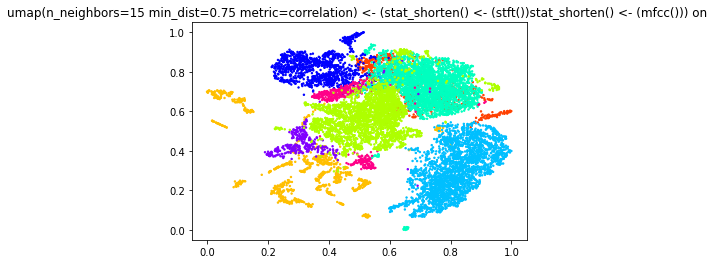

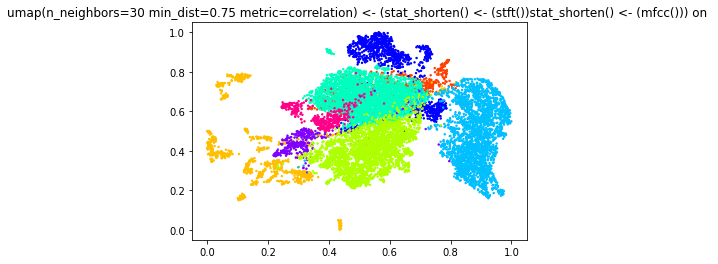

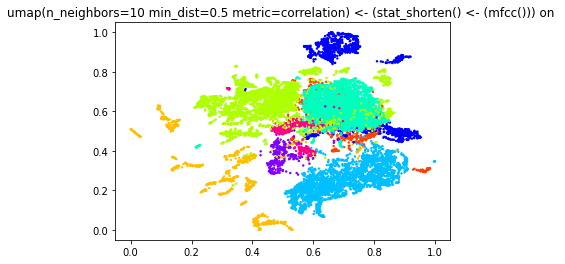

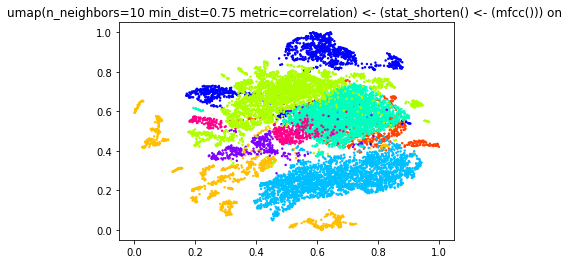

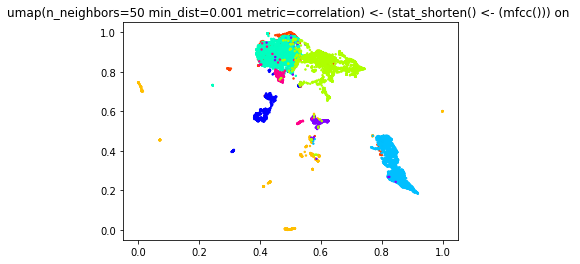

In [6]:
n_neighbors = [5, 10, 15, 30, 50, 100, 200]
min_dists = [0.0, 0.001, 0.01, 0.1, 0.5, 0.75, 0.99]
umap_algs = [
    {
        "name": "umap",
        "args": {"n_neighbors": n, "min_dist": d, "metric": "correlation"},
    }
    for n in n_neighbors
    for d in min_dists
]
umap_funcalls = [DimredAlgorithmFactory.get_instance(**d) for d in umap_algs]

# Construct dimred funcalls with feature set suffixes for calculation & retrieval from disk
all_dimred_funcalls = umap_funcalls + [embedding_pca]


def plot_single(dataset, dimred_store, dimred_alg_fc, rows):
    print(dataset.data.attrs)
    color_map = dataset.color_map(rows)
    plot2D(
        dimred_store[dimred_alg_fc.__repr__()],
        color_map,
        str(dimred_alg_fc),
        "",
    )
    print(format_metrics(dimred_store[dimred_alg_fc.__repr__()].attrs))


all_dimred_funcalls_with_features = []
with dataset._store:
    rows = dataset.get_subset_rows("training")

    for feature_set in feature_sets_to_dimred:
        dimred_store, local_dimred_fcs, feature_collection = apply_dimred(
            dataset,
            all_dimred_funcalls,
            feature_set,
            recalculate=False,
            score=True,
            rows=rows,
        )
        all_dimred_funcalls_with_features += local_dimred_fcs
        with dimred_store:
            # scores = normalize_scores(dimred_store, local_dimred_fcs)
            # plot_grid_search(
            #     feature_collection,
            #     dataset,
            #     dimred_store,
            #     local_dimred_fcs,
            #     n_neighbors,
            #     min_dists,
            #     rows,
            #     title=f"Umap over {[ str(f) for f in feature_set ]}",
            #     scores=scores,
            # )
            pass

dimred_store = AudiovizDataStoreFactory.get_instance(
    os.path.join(DATA_DIMRED_DIR, f"{dataset.name}_dimred.h5"), "h5"
)
with dimred_store, dataset._store:
    scores = normalize_scores(dimred_store, all_dimred_funcalls_with_features)

    sorted_indexes = np.argsort(
        [s["Total"] for s in scores],
    )[::-1]
    for i in range(5):
        plot_single(
            dataset,
            dimred_store,
            all_dimred_funcalls_with_features[sorted_indexes[i]],
            rows,
        )